# Vienna Christmas Market Optimizer - Analysis Notebook

This notebook demonstrates the optimization algorithms and visualizations.

In [1]:
import sys
import os

# Add src to path
sys.path.insert(0, os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.data_structures import load_problem_instance, MultiDaySolution
from src.models.aco import AntColonyOptimizer
from src.models.greedy import GreedyOptimizer
from src.visualization.plotter import Visualizer

# Try to import folium for interactive maps
try:
    import folium
    FOLIUM_AVAILABLE = True
    print("✓ Folium available for interactive maps")
except ImportError:
    FOLIUM_AVAILABLE = False
    print("✗ Folium not available. Install with: pip install folium")

sns.set_style('whitegrid')
%matplotlib inline

✓ Folium available for interactive maps


## 1. Load Problem Instance

In [2]:
# Load demo data
problem = load_problem_instance(
    markets_path='../data/real/markets.json',
    travel_times_path='../data/real/travel_times.json',
    num_days=1,
    stay_durations=[30],
    transfer_buffer=5
)

print(f"Loaded {len(problem.markets)} markets")
print(f"\nDay bounds: {problem.get_earliest_opening()} - {problem.get_latest_closing()}")

Loaded 32 markets

Day bounds: 09:00:00 - 23:00:00


## 2. Explore Market Data

In [3]:
# Display market information
import pandas as pd

market_data = []
for m in problem.markets:
    market_data.append({
        'ID': m.id,
        'Name': m.name,
        'Opening': m.opening_time.strftime('%H:%M'),
        'Closing': m.closing_time.strftime('%H:%M'),
        'Latitude': m.latitude,
        'Longitude': m.longitude
    })

df_markets = pd.DataFrame(market_data)
df_markets

,ID,Name,Opening,Closing,Latitude,Longitude
0,1,MQ,14:00,23:00,48.211546,16.383889
1,2,Altes AKH,11:00,23:00,48.214995,16.353884
2,3,Am Hof,10:00,21:00,48.211198,16.367850
3,4,Spittelberg,10:00,21:30,48.202981,16.355731
4,5,Stephansplatz,11:00,21:00,48.208313,16.372523
5,6,Opera,11:00,21:00,48.202963,16.369513
6,7,Türkenschanzpark,12:00,22:00,48.237230,16.334506
7,8,Maria-Theresien-Platz,11:00,21:00,48.204764,16.360930
8,9,Blumengärten Hirschstetten,10:00,22:00,48.239008,16.474302
9,10,Palais Liechtenstein,11:00,21:00,48.222661,16.359589


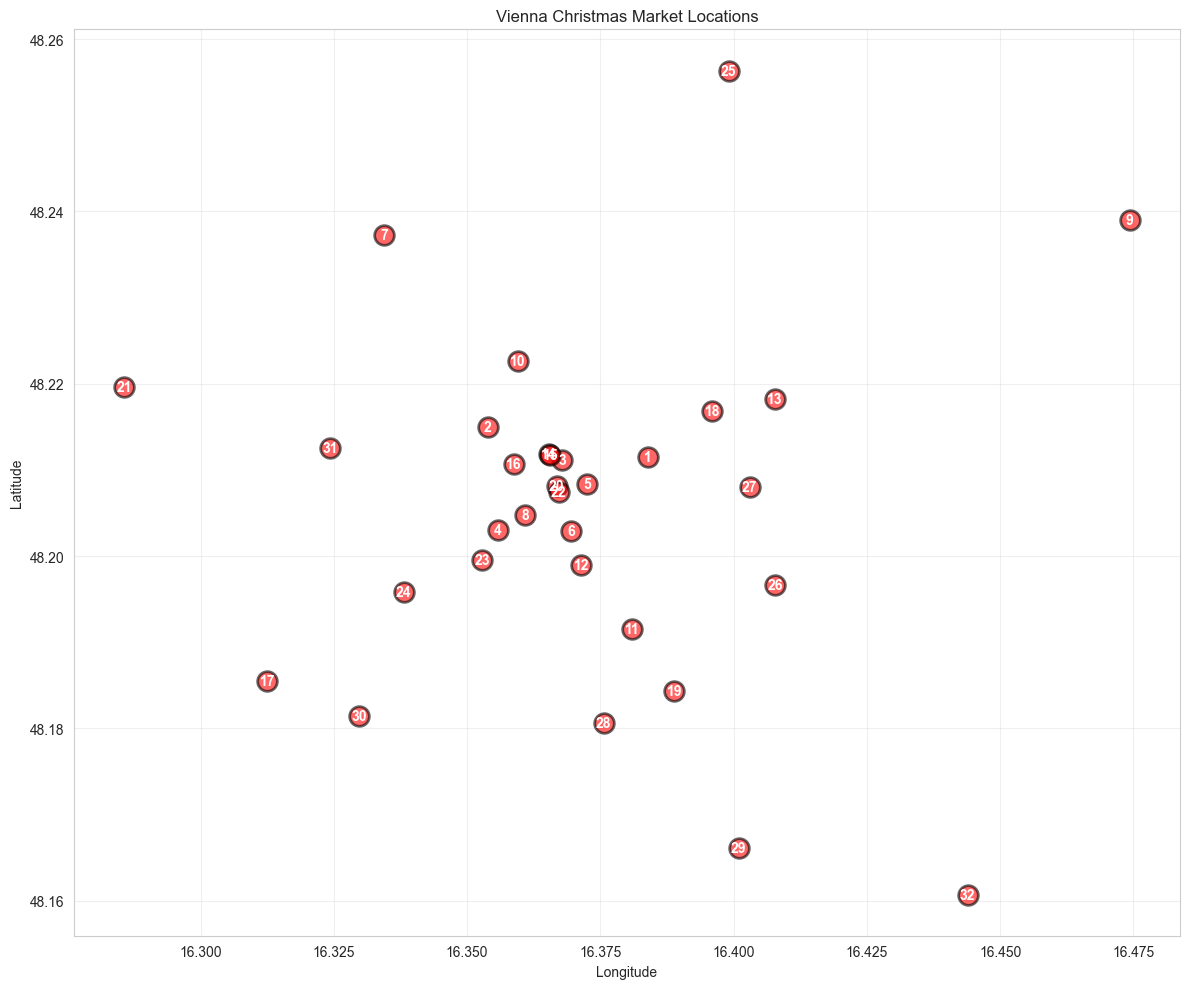

In [4]:
# Visualize market locations
fig, ax = plt.subplots(figsize=(12, 10))

lats = [m.latitude for m in problem.markets]
lons = [m.longitude for m in problem.markets]

ax.scatter(lons, lats, s=200, alpha=0.6, c='red', edgecolors='black', linewidths=2)

for m in problem.markets:
    ax.annotate(f"{m.id}", (m.longitude, m.latitude), 
               fontsize=10, ha='center', va='center', color='white', fontweight='bold')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Vienna Christmas Market Locations')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Run ACO Algorithm

In [5]:
# Initialize ACO
aco = AntColonyOptimizer(
    problem=problem,
    num_ants=50,
    num_iterations=100,
    alpha=1.0,
    beta=2.0,
    gamma=1.5,
    evaporation=0.5,
    random_seed=42
)

# Solve
print("Running ACO...")
aco_solution = aco.solve(day=1)

print(f"\nACO Solution:")
print(f"Markets visited: {aco_solution.total_markets_visited}")
print(f"Travel time: {aco_solution.total_travel_time:.1f} minutes")
print(f"Total time: {aco_solution.total_time:.1f} minutes")
print(f"Route: {aco_solution.route}")

Running ACO...

ACO Solution:
Markets visited: 18
Travel time: 190.5 minutes
Total time: 730.5 minutes
Route: [19, 28, 14, 15, 3, 20, 22, 6, 12, 11, 26, 24, 23, 4, 8, 16, 13, 2]


## 4. Run Greedy Algorithm

In [6]:
# Initialize Greedy
greedy = GreedyOptimizer(
    problem=problem,
    heuristic='hybrid',
    distance_weight=0.4,
    time_window_weight=0.6
)

# Solve
print("Running Greedy...")
greedy_solution = greedy.solve(day=1)

print(f"\nGreedy Solution:")
print(f"Markets visited: {greedy_solution.total_markets_visited}")
print(f"Travel time: {greedy_solution.total_travel_time:.1f} minutes")
print(f"Total time: {greedy_solution.total_time:.1f} minutes")
print(f"Route: {greedy_solution.route}")

Running Greedy...

Greedy Solution:
Markets visited: 11
Travel time: 232.2 minutes
Total time: 562.2 minutes
Route: [3, 14, 2, 1, 18, 13, 16, 31, 7, 9, 19]


## 5. Compare Algorithms

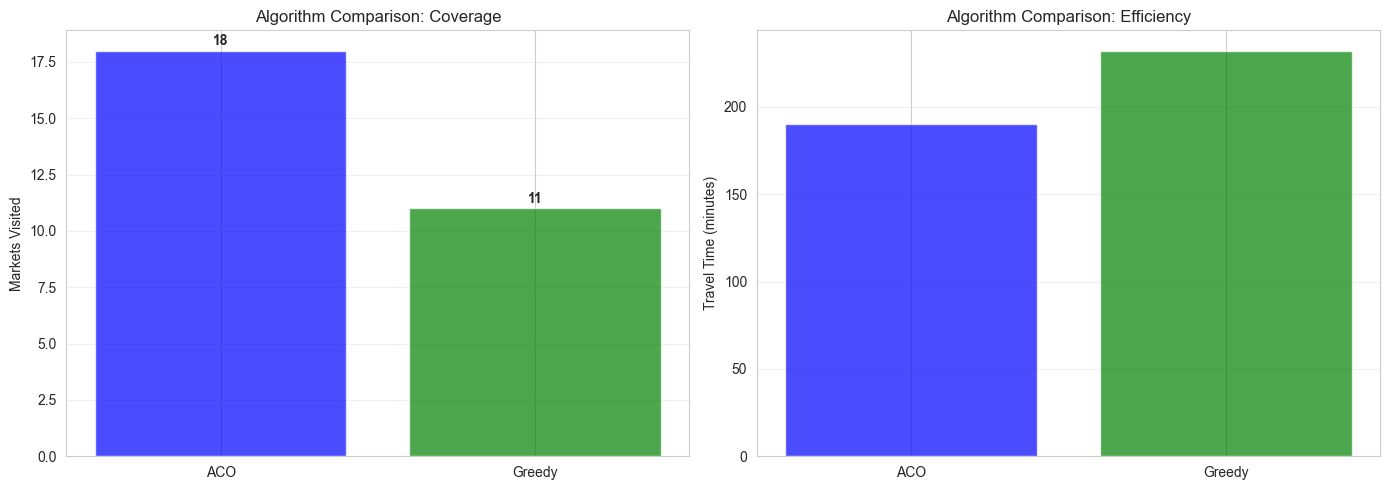

In [7]:
# Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Markets visited
algorithms = ['ACO', 'Greedy']
markets_visited = [aco_solution.total_markets_visited, greedy_solution.total_markets_visited]

axes[0].bar(algorithms, markets_visited, color=['blue', 'green'], alpha=0.7)
axes[0].set_ylabel('Markets Visited')
axes[0].set_title('Algorithm Comparison: Coverage')
axes[0].grid(True, axis='y', alpha=0.3)

for i, v in enumerate(markets_visited):
    axes[0].text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')

# Travel time
travel_times = [aco_solution.total_travel_time, greedy_solution.total_travel_time]

axes[1].bar(algorithms, travel_times, color=['blue', 'green'], alpha=0.7)
axes[1].set_ylabel('Travel Time (minutes)')
axes[1].set_title('Algorithm Comparison: Efficiency')
axes[1].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Visualize Solutions

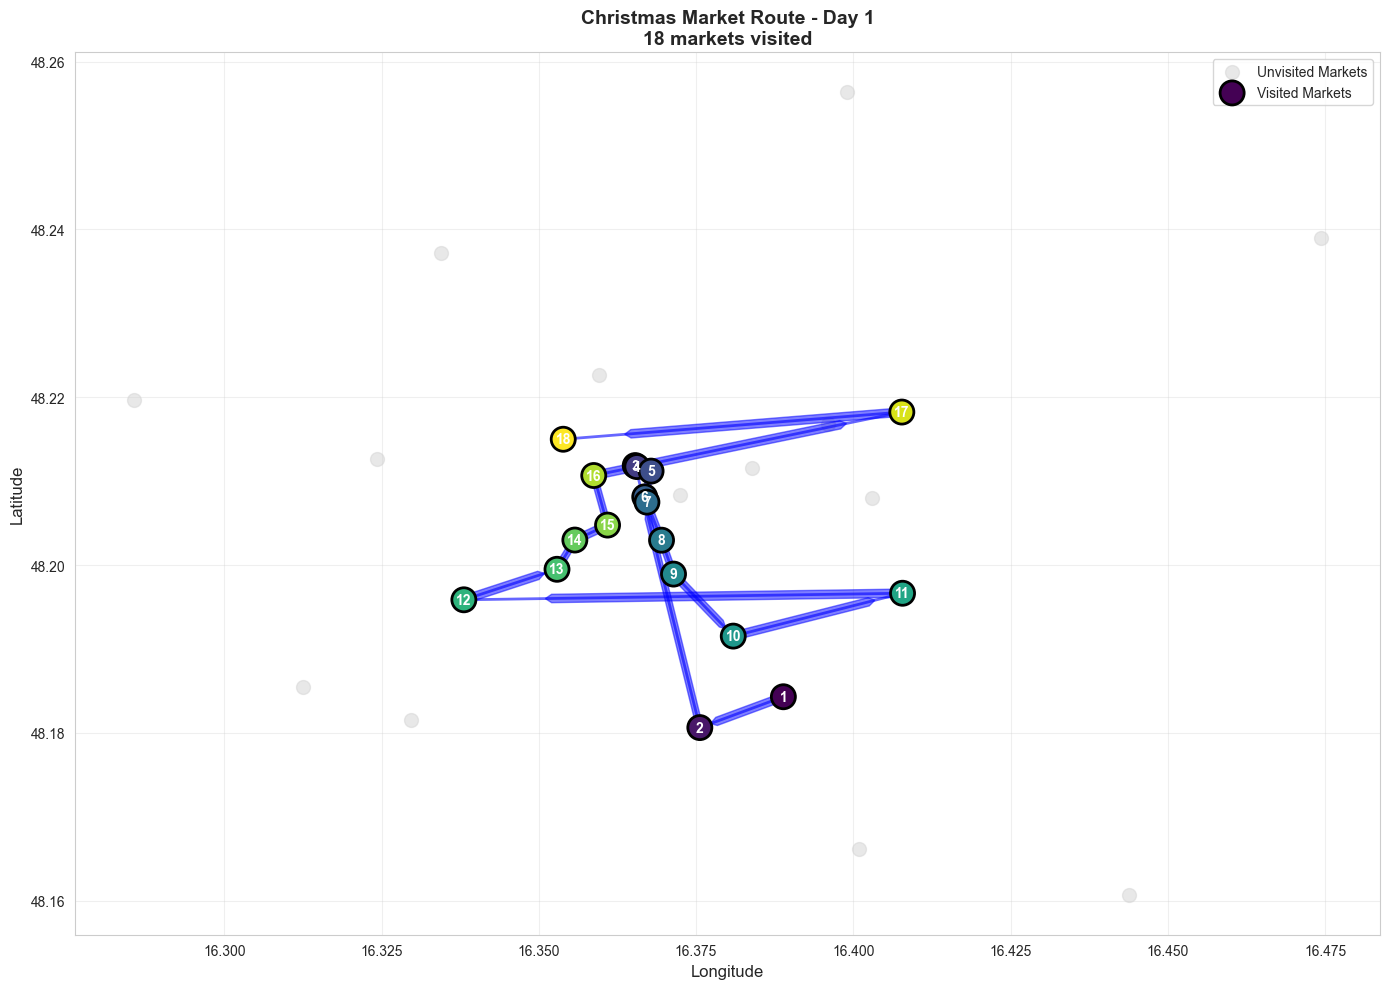

/Users/paulhimstedt/Documents/TU_MASTER/self_organizing_systems/Group_02_Seidel_Rally_Vienna_ACO/src/visualization/plotter.py:413: UserWarning: color argument of Icon should be one of: {'lightgreen', 'gray', 'red', 'pink', 'purple', 'darkred', 'orange', 'lightblue', 'blue', 'lightgray', 'green', 'darkblue', 'black', 'darkpurple', 'darkgreen', 'cadetblue', 'lightred', 'beige', 'white'}.
  icon=folium.Icon(color=color, icon='info-sign'),


In [8]:
# Initialize visualizer
viz = Visualizer(problem, output_dir='../results')

# Plot ACO route (static)
viz.plot_route_map(aco_solution, save=False)
plt.show()

# Plot interactive map (if available)
if FOLIUM_AVAILABLE:
    interactive_map = viz.plot_interactive_map(aco_solution, save=False)
    display(interactive_map)
else:
    print("Install folium for interactive maps: pip install folium")

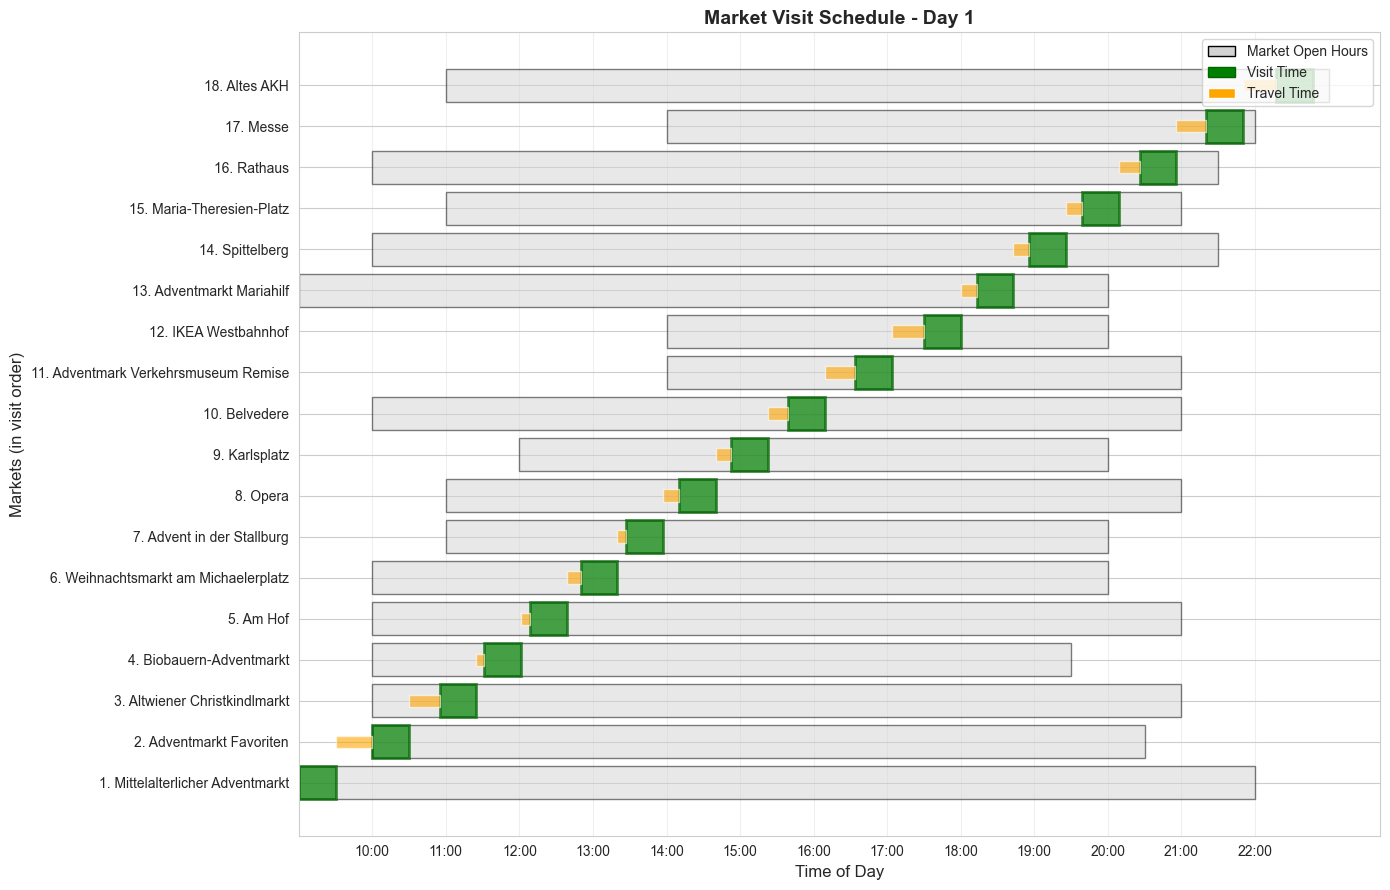

In [9]:
# Plot Gantt chart
viz.plot_gantt_chart(aco_solution, save=False)
plt.show()

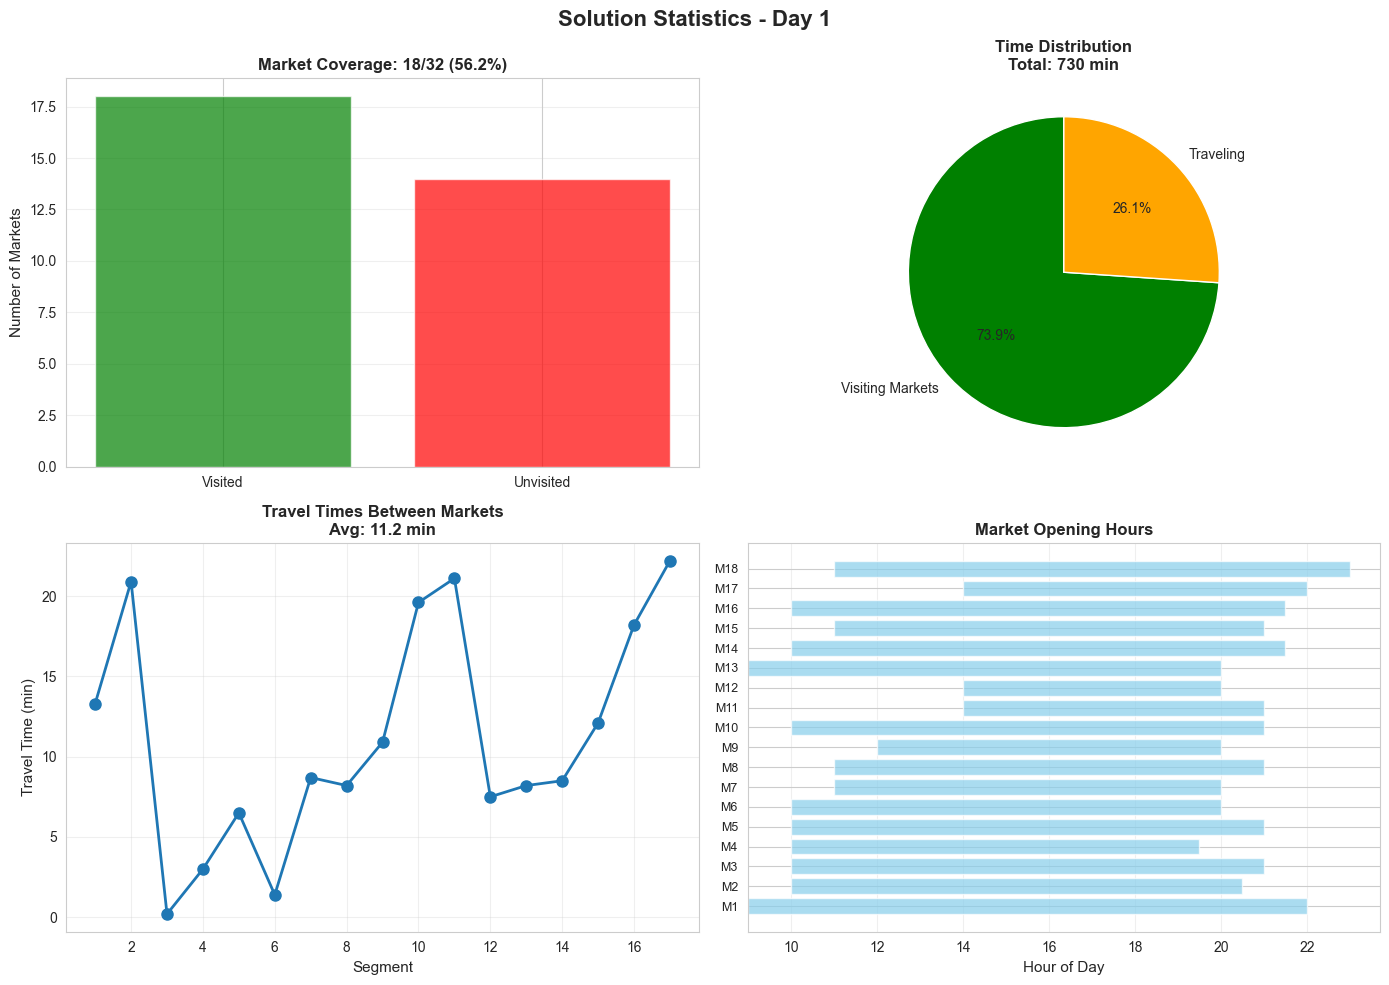

In [10]:
# Plot statistics
viz.plot_statistics(aco_solution, save=False)
plt.show()

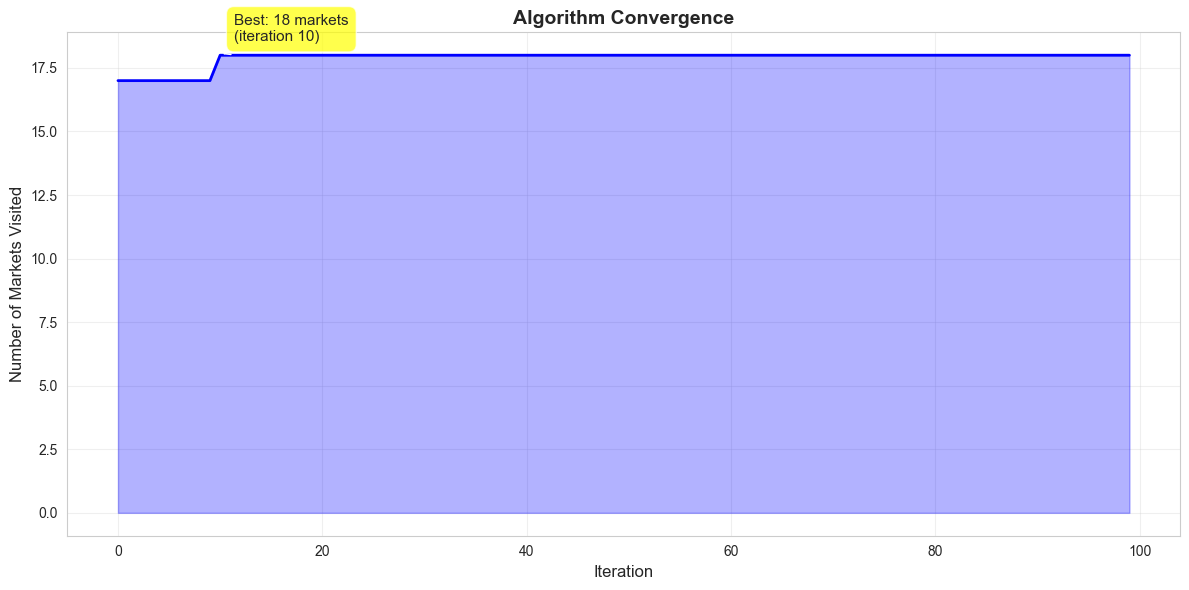

In [11]:
# Plot convergence
viz.plot_convergence(aco.convergence_history, save=False)
plt.show()

## 7. Multi-Day Scenario

In [12]:
# Load multi-day problem (configurable for 2-3 days)
num_days = 3  # Change this to 2 or 3
stay_durations = [30, 45, 60][:num_days]  # Different durations per day

problem_multiday = load_problem_instance(
    markets_path='../data/real/markets.json',
    travel_times_path='../data/real/travel_times.json',
    num_days=num_days,
    stay_durations=stay_durations,
    transfer_buffer=5
)

# Solve day by day
excluded = []
solutions = []

for day in range(1, num_days + 1):
    aco_day = AntColonyOptimizer(problem_multiday, num_ants=50, num_iterations=50, random_seed=42)
    sol = aco_day.solve(day=day, excluded_markets=excluded)
    solutions.append(sol)
    excluded.extend(sol.route)
    print(f"Day {day}: {sol.total_markets_visited} markets")

# Create multi-day solution
multi_sol = MultiDaySolution(
    daily_solutions=solutions,
    total_markets_visited=sum(s.total_markets_visited for s in solutions),
    unvisited_markets=[m.id for m in problem_multiday.markets if m.id not in excluded]
)

print(f"\nTotal: {multi_sol.total_markets_visited}/{len(problem_multiday.markets)} markets")
print(f"Unvisited: {len(multi_sol.unvisited_markets)} markets")

Day 1: 18 markets
Day 2: 11 markets
Day 3: 3 markets

Total: 32/32 markets
Unvisited: 0 markets


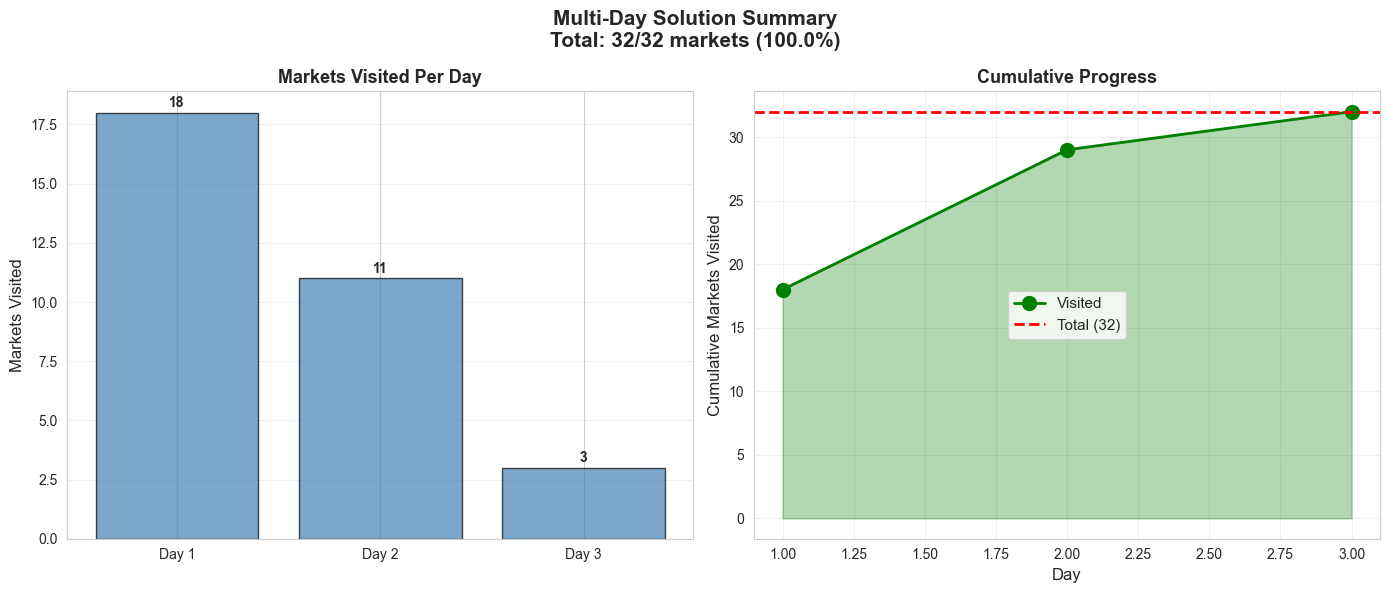

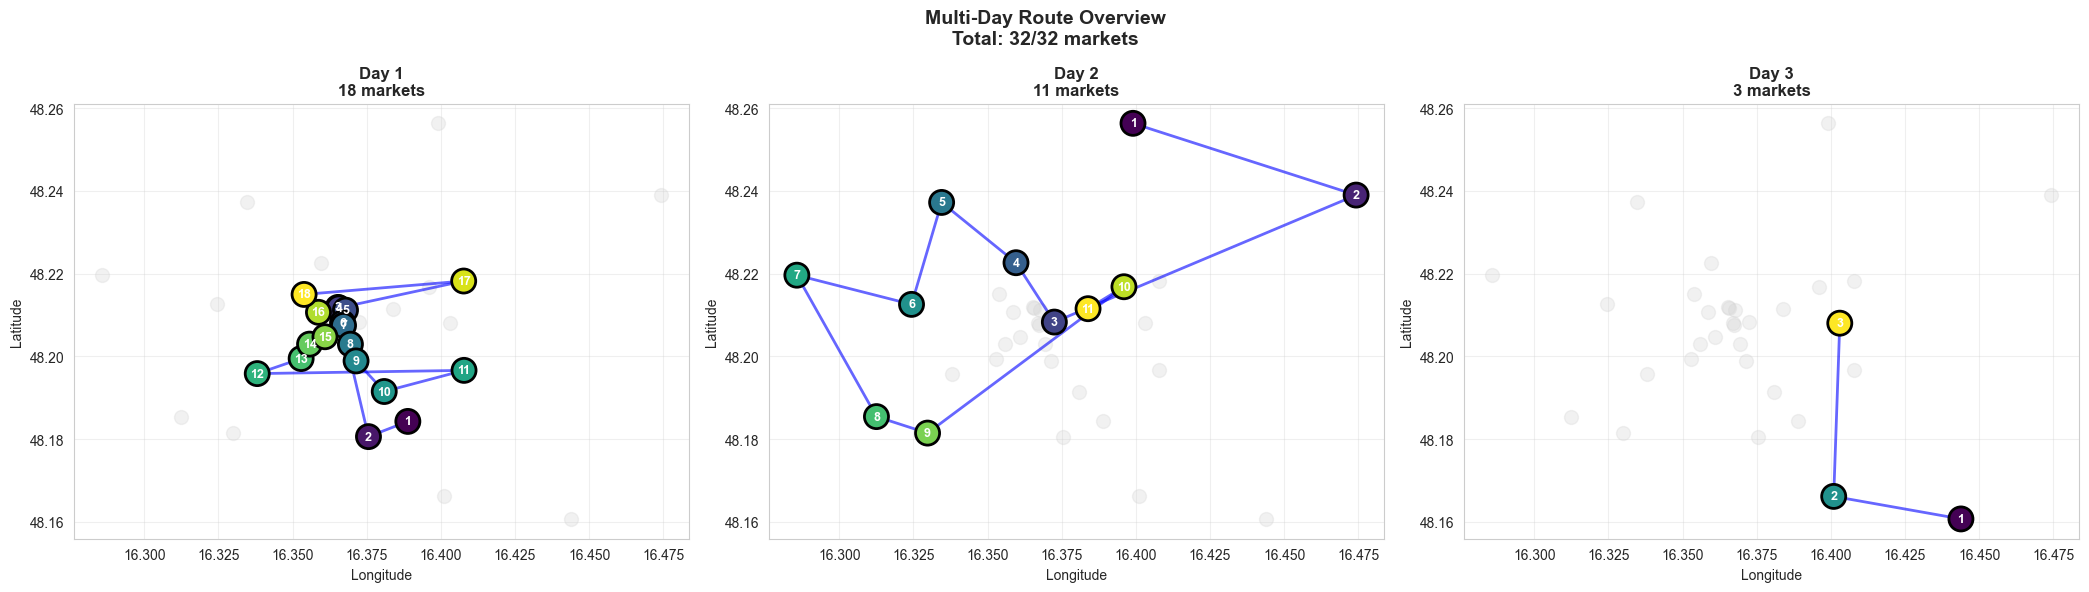

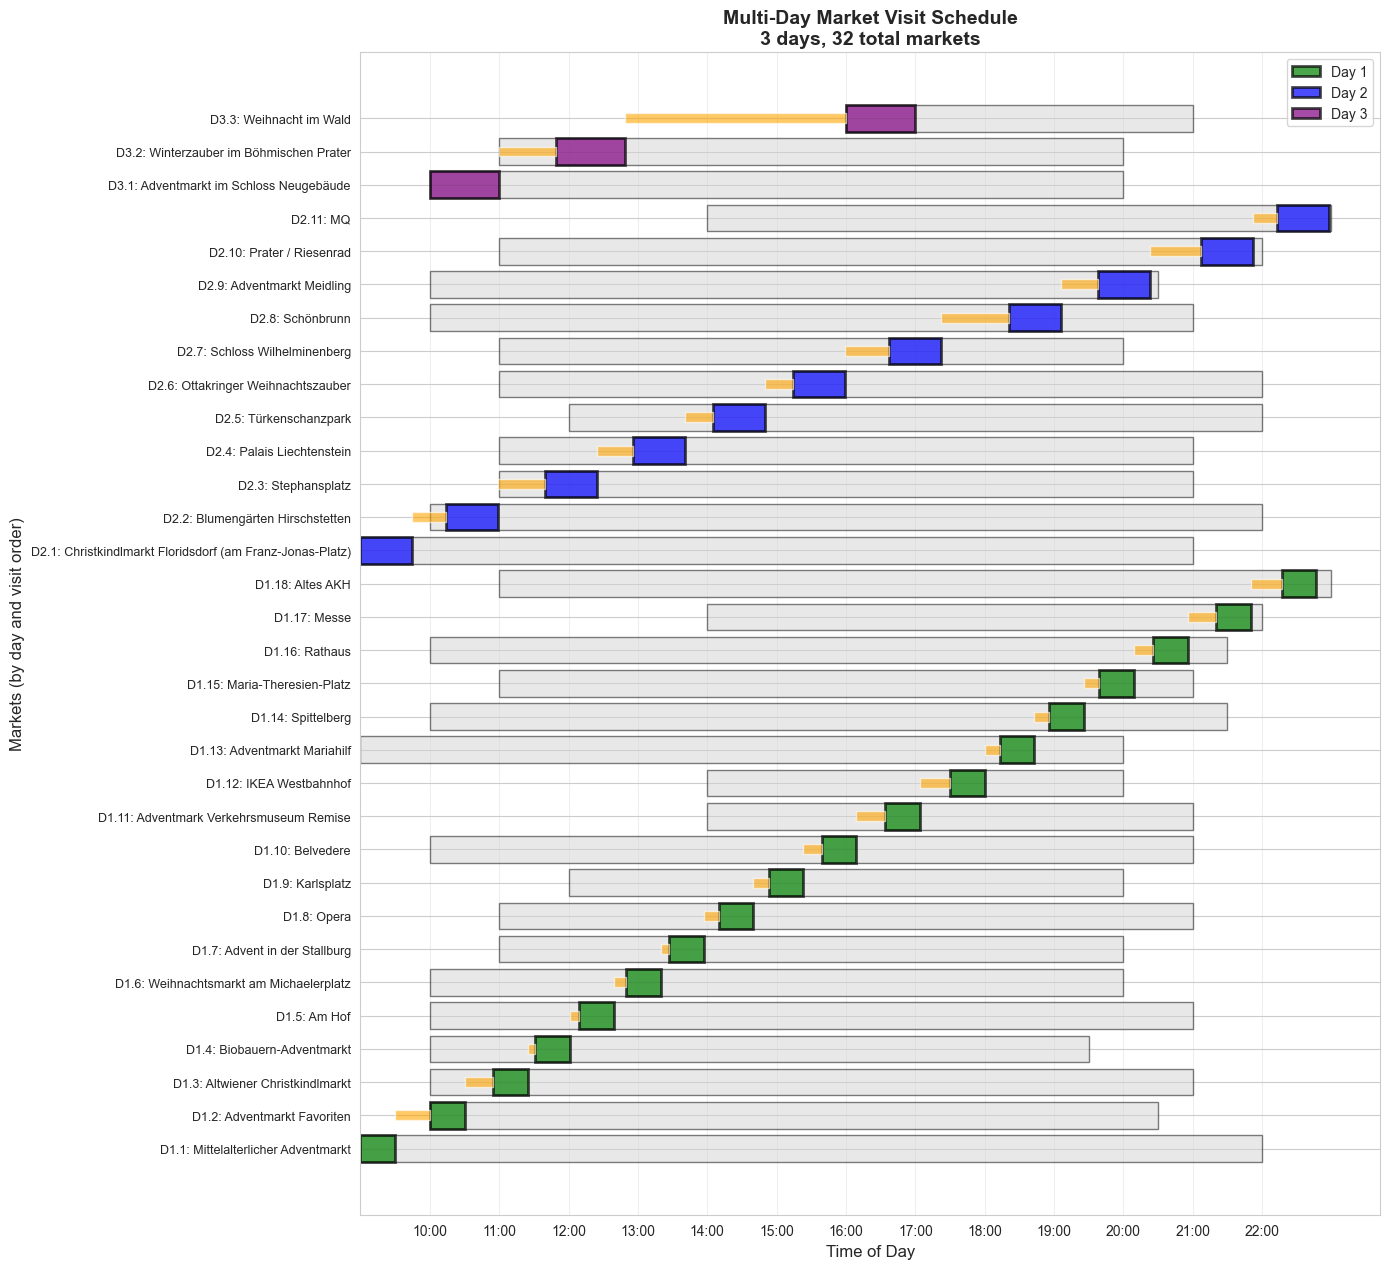


DAY 1 DETAILS

SOLUTION REPORT - DAY 1

Markets Visited: 18/32
Total Travel Time: 190.5 minutes
Total Time: 730.5 minutes

Detailed Route:
----------------------------------------------------------------------
1. Mittelalterlicher Adventmarkt
   Arrive: 09:00 | Depart: 09:30 | Open: 09:00-22:00
2. Adventmarkt Favoriten
   Arrive: 10:00 | Depart: 10:30 | Open: 10:00-20:30 (travel: 13 min)
3. Altwiener Christkindlmarkt
   Arrive: 10:55 | Depart: 11:25 | Open: 10:00-21:00 (travel: 21 min)
4. Biobauern-Adventmarkt
   Arrive: 11:31 | Depart: 12:01 | Open: 10:00-19:30 (travel: 0 min)
5. Am Hof
   Arrive: 12:09 | Depart: 12:39 | Open: 10:00-21:00 (travel: 3 min)
6. Weihnachtsmarkt am Michaelerplatz
   Arrive: 12:50 | Depart: 13:20 | Open: 10:00-20:00 (travel: 6 min)
7. Advent in der Stallburg
   Arrive: 13:27 | Depart: 13:57 | Open: 11:00-20:00 (travel: 1 min)
8. Opera
   Arrive: 14:10 | Depart: 14:40 | Open: 11:00-21:00 (travel: 9 min)
9. Karlsplatz
   Arrive: 14:53 | Depart: 15:23 | Open: 

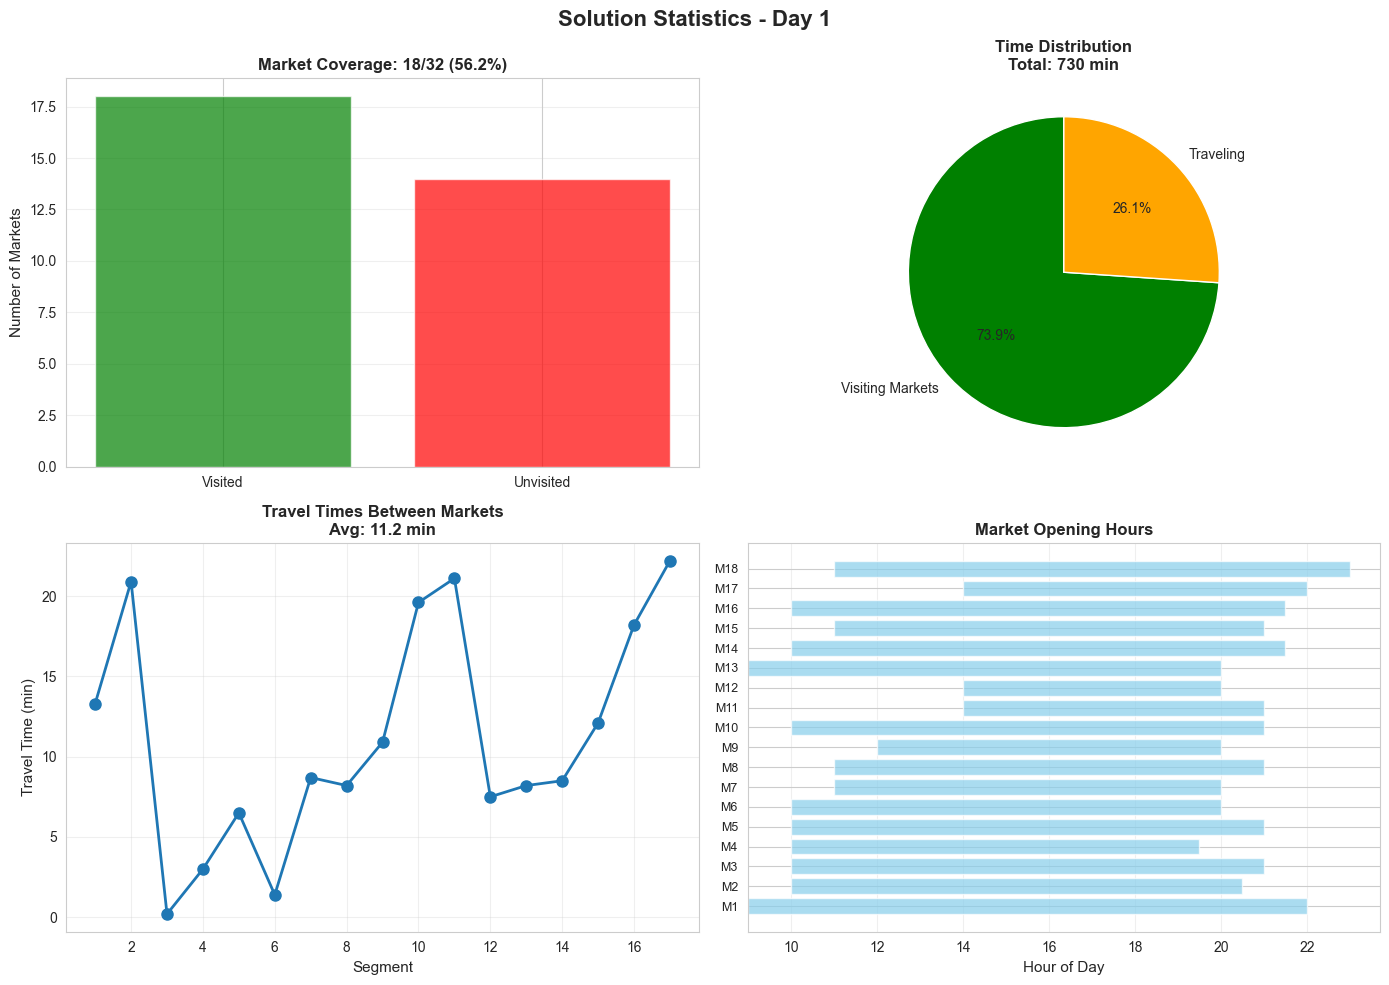


DAY 2 DETAILS

SOLUTION REPORT - DAY 2

Markets Visited: 11/32
Total Travel Time: 293.1 minutes
Total Time: 788.1 minutes

Detailed Route:
----------------------------------------------------------------------
1. Christkindlmarkt Floridsdorf (am Franz-Jonas-Platz)
   Arrive: 09:00 | Depart: 09:45 | Open: 09:00-21:00
2. Blumengärten Hirschstetten
   Arrive: 10:14 | Depart: 10:59 | Open: 10:00-22:00 (travel: 24 min)
3. Stephansplatz
   Arrive: 11:40 | Depart: 12:25 | Open: 11:00-21:00 (travel: 37 min)
4. Palais Liechtenstein
   Arrive: 12:56 | Depart: 13:41 | Open: 11:00-21:00 (travel: 26 min)
5. Türkenschanzpark
   Arrive: 14:05 | Depart: 14:50 | Open: 12:00-22:00 (travel: 18 min)
6. Ottakringer Weihnachtszauber
   Arrive: 15:14 | Depart: 15:59 | Open: 11:00-22:00 (travel: 19 min)
7. Schloss Wilhelminenberg
   Arrive: 16:37 | Depart: 17:22 | Open: 11:00-20:00 (travel: 33 min)
8. Schönbrunn
   Arrive: 18:21 | Depart: 19:06 | Open: 10:00-21:00 (travel: 55 min)
9. Adventmarkt Meidling
   

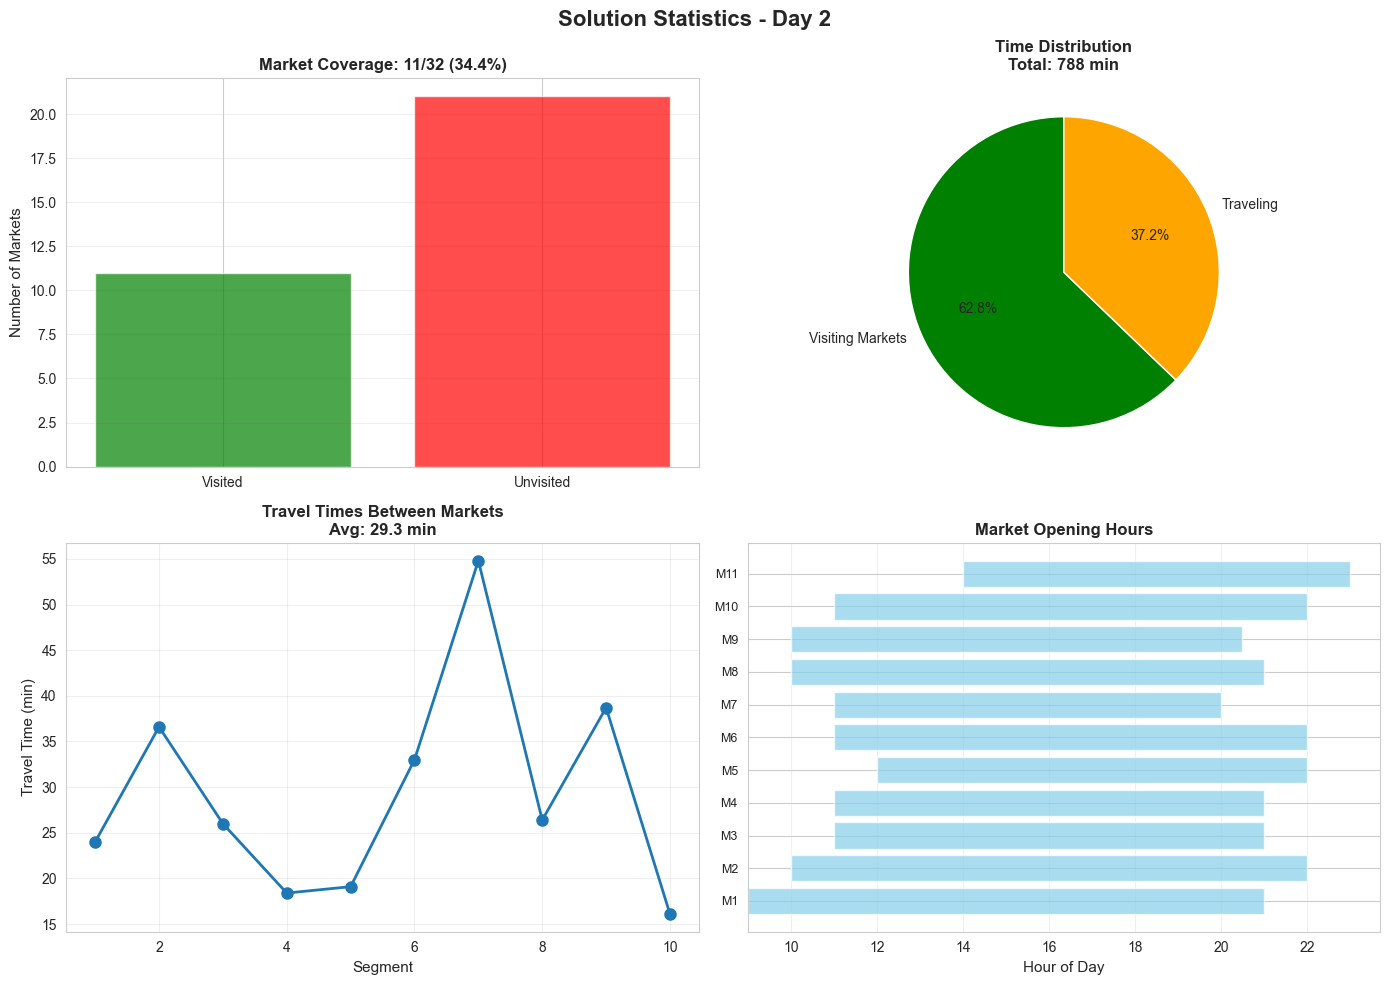


DAY 3 DETAILS

SOLUTION REPORT - DAY 3

Markets Visited: 3/32
Total Travel Time: 98.3 minutes
Total Time: 278.3 minutes

Detailed Route:
----------------------------------------------------------------------
1. Adventmarkt im Schloss Neugebäude
   Arrive: 10:00 | Depart: 11:00 | Open: 10:00-20:00
2. Winterzauber im Böhmischen Prater
   Arrive: 11:49 | Depart: 12:49 | Open: 11:00-20:00 (travel: 45 min)
3. Weihnacht im Wald
   Arrive: 16:00 | Depart: 17:00 | Open: 16:00-21:00 (travel: 54 min)



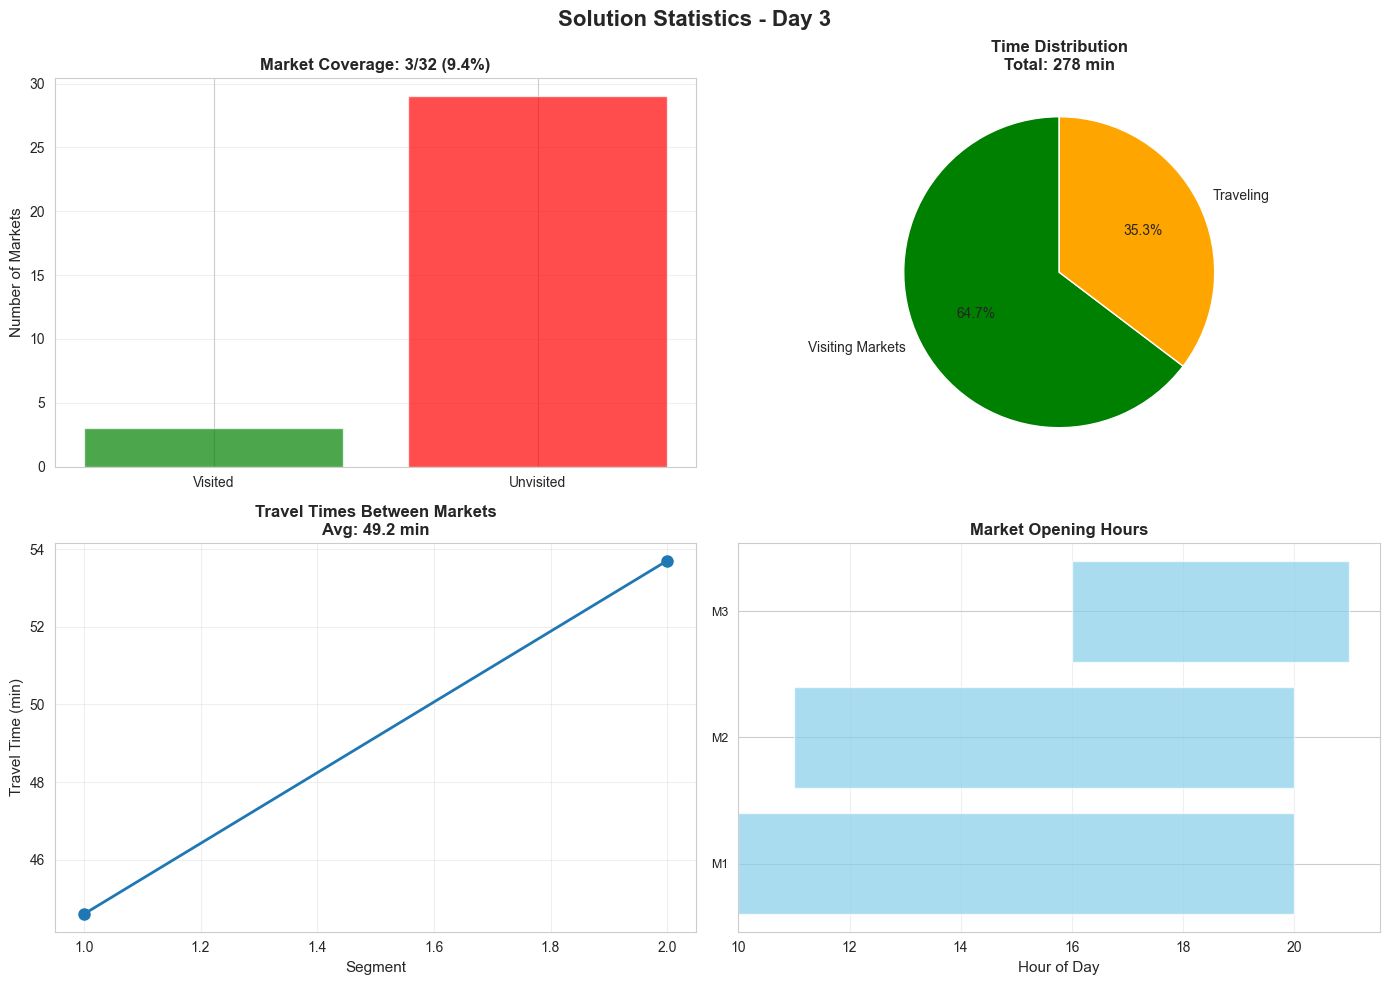

In [13]:
# Visualize multi-day summary
viz_multi = Visualizer(problem_multiday, output_dir='../results')

# 1. Summary statistics
viz_multi.plot_multi_day_summary(multi_sol, save=False)
plt.show()

# 2. All routes side by side
viz_multi.plot_multi_day_routes(multi_sol, save=False)
plt.show()

# 3. Combined Gantt chart
viz_multi.plot_multi_day_gantt(multi_sol, save=False)
plt.show()

# 4. Interactive multi-day map
if FOLIUM_AVAILABLE:
    multi_map = viz_multi.plot_multi_day_interactive_map(multi_sol, save=False)
    display(multi_map)

# 5. Individual day details
for day_idx, sol in enumerate(multi_sol.daily_solutions):
    print(f"\n{'='*70}")
    print(f"DAY {sol.day} DETAILS")
    print('='*70)
    viz_multi.create_solution_report(sol)
    
    # Plot individual day statistics
    viz_multi.plot_statistics(sol, save=False)
    plt.show()

## 8. Parameter Sensitivity Analysis

Stay duration 15min: 12 markets
Stay duration 20min: 12 markets
Stay duration 30min: 12 markets
Stay duration 45min: 12 markets
Stay duration 60min: 10 markets


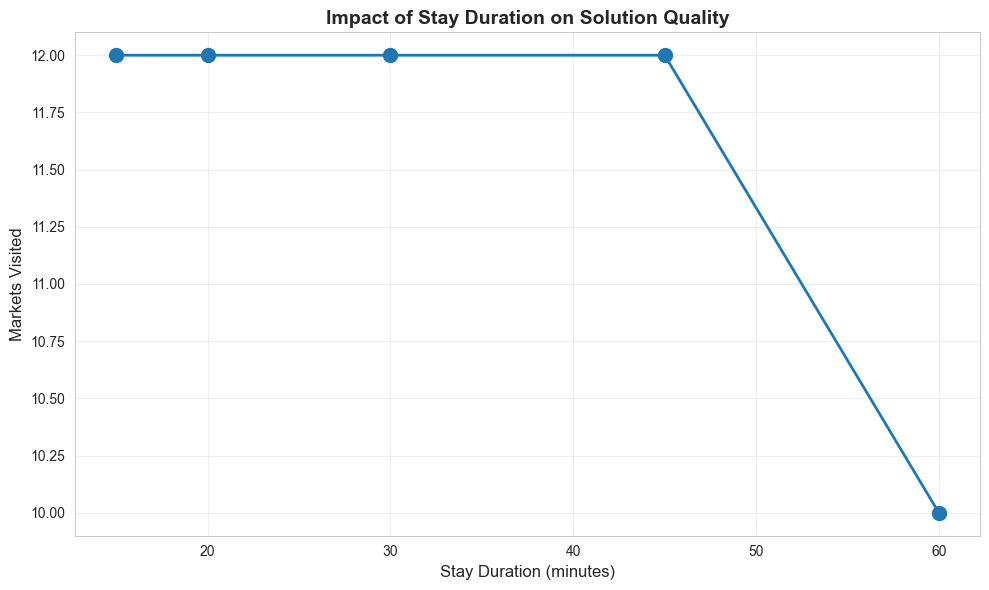

In [14]:
# Test different stay durations
stay_durations = [15, 20, 30, 45, 60]
results = []

for duration in stay_durations:
    prob = load_problem_instance(
        '../data/demo/markets.json',
        '../data/demo/travel_times.json',
        num_days=1,
        stay_durations=[duration]
    )
    
    aco_test = AntColonyOptimizer(prob, num_ants=30, num_iterations=50, random_seed=42)
    sol = aco_test.solve()
    results.append(sol.total_markets_visited)
    print(f"Stay duration {duration}min: {sol.total_markets_visited} markets")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(stay_durations, results, 'o-', linewidth=2, markersize=10)
plt.xlabel('Stay Duration (minutes)', fontsize=12)
plt.ylabel('Markets Visited', fontsize=12)
plt.title('Impact of Stay Duration on Solution Quality', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 9. Export Results

In [15]:
# Create detailed solution report
viz.create_solution_report(aco_solution)


SOLUTION REPORT - DAY 1

Markets Visited: 18/32
Total Travel Time: 190.5 minutes
Total Time: 730.5 minutes

Detailed Route:
----------------------------------------------------------------------
1. Mittelalterlicher Adventmarkt
   Arrive: 09:00 | Depart: 09:30 | Open: 09:00-22:00
2. Adventmarkt Favoriten
   Arrive: 10:00 | Depart: 10:30 | Open: 10:00-20:30 (travel: 13 min)
3. Altwiener Christkindlmarkt
   Arrive: 10:55 | Depart: 11:25 | Open: 10:00-21:00 (travel: 21 min)
4. Biobauern-Adventmarkt
   Arrive: 11:31 | Depart: 12:01 | Open: 10:00-19:30 (travel: 0 min)
5. Am Hof
   Arrive: 12:09 | Depart: 12:39 | Open: 10:00-21:00 (travel: 3 min)
6. Weihnachtsmarkt am Michaelerplatz
   Arrive: 12:50 | Depart: 13:20 | Open: 10:00-20:00 (travel: 6 min)
7. Advent in der Stallburg
   Arrive: 13:27 | Depart: 13:57 | Open: 11:00-20:00 (travel: 1 min)
8. Opera
   Arrive: 14:10 | Depart: 14:40 | Open: 11:00-21:00 (travel: 9 min)
9. Karlsplatz
   Arrive: 14:53 | Depart: 15:23 | Open: 12:00-20:00 (tr

Saved route map to ../results/notebook_route.png
Saved Gantt chart to ../results/notebook_gantt.png
Saved statistics plot to ../results/notebook_stats.png
Saved convergence plot to ../results/notebook_convergence.png
All visualizations saved to results/ directory


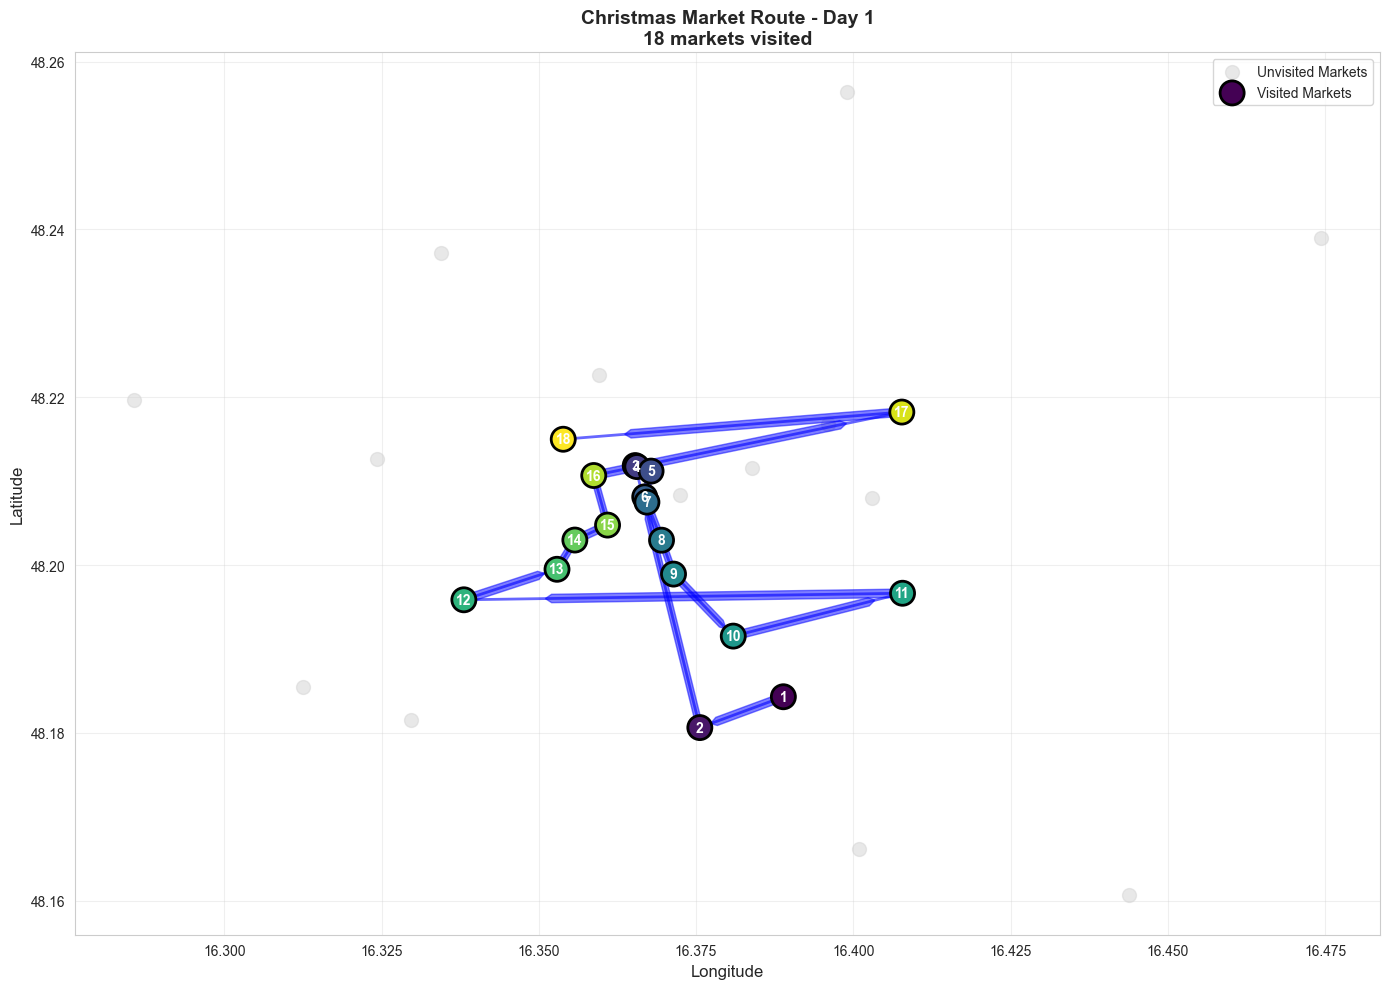

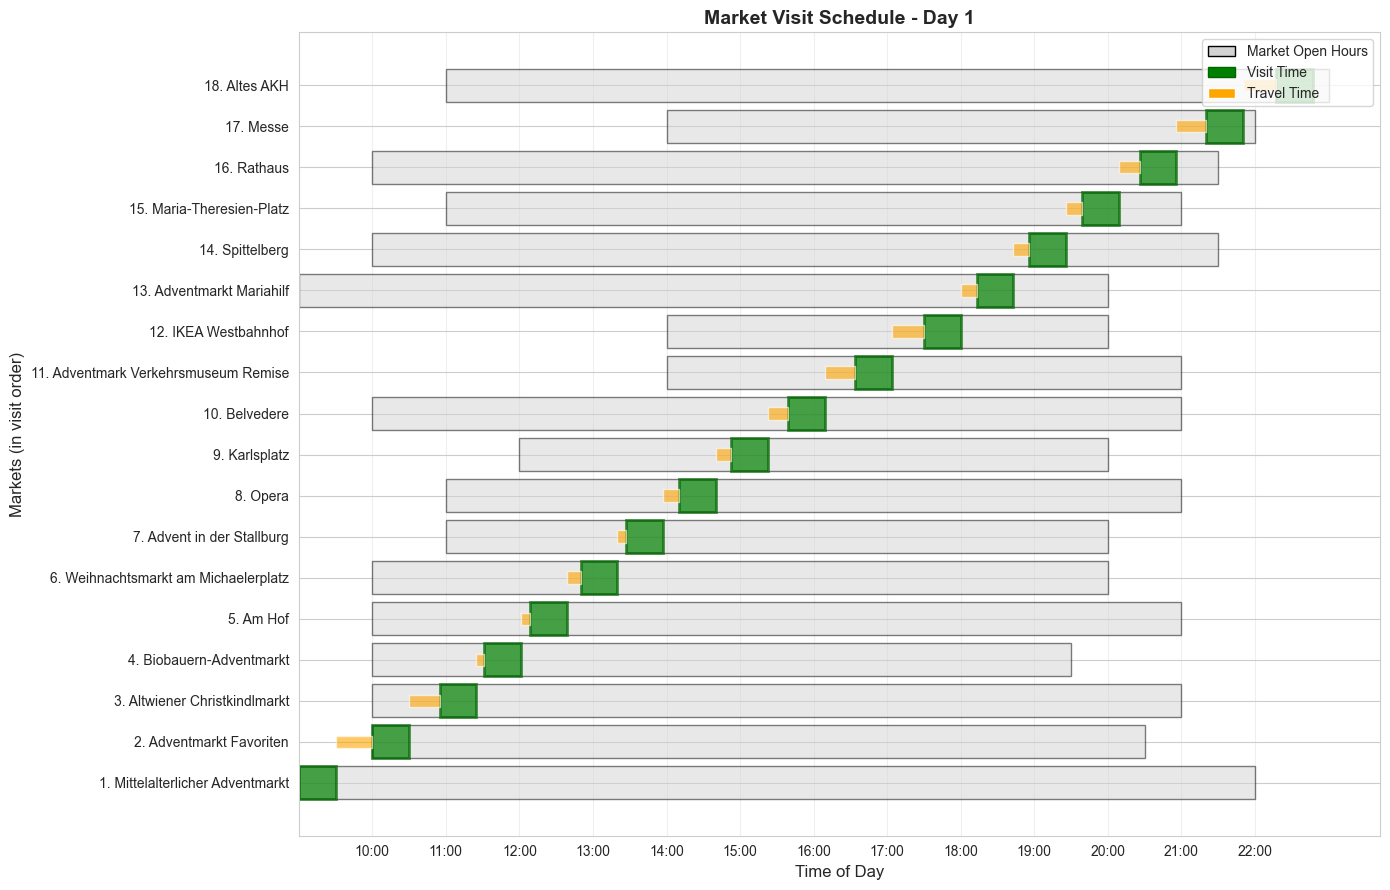

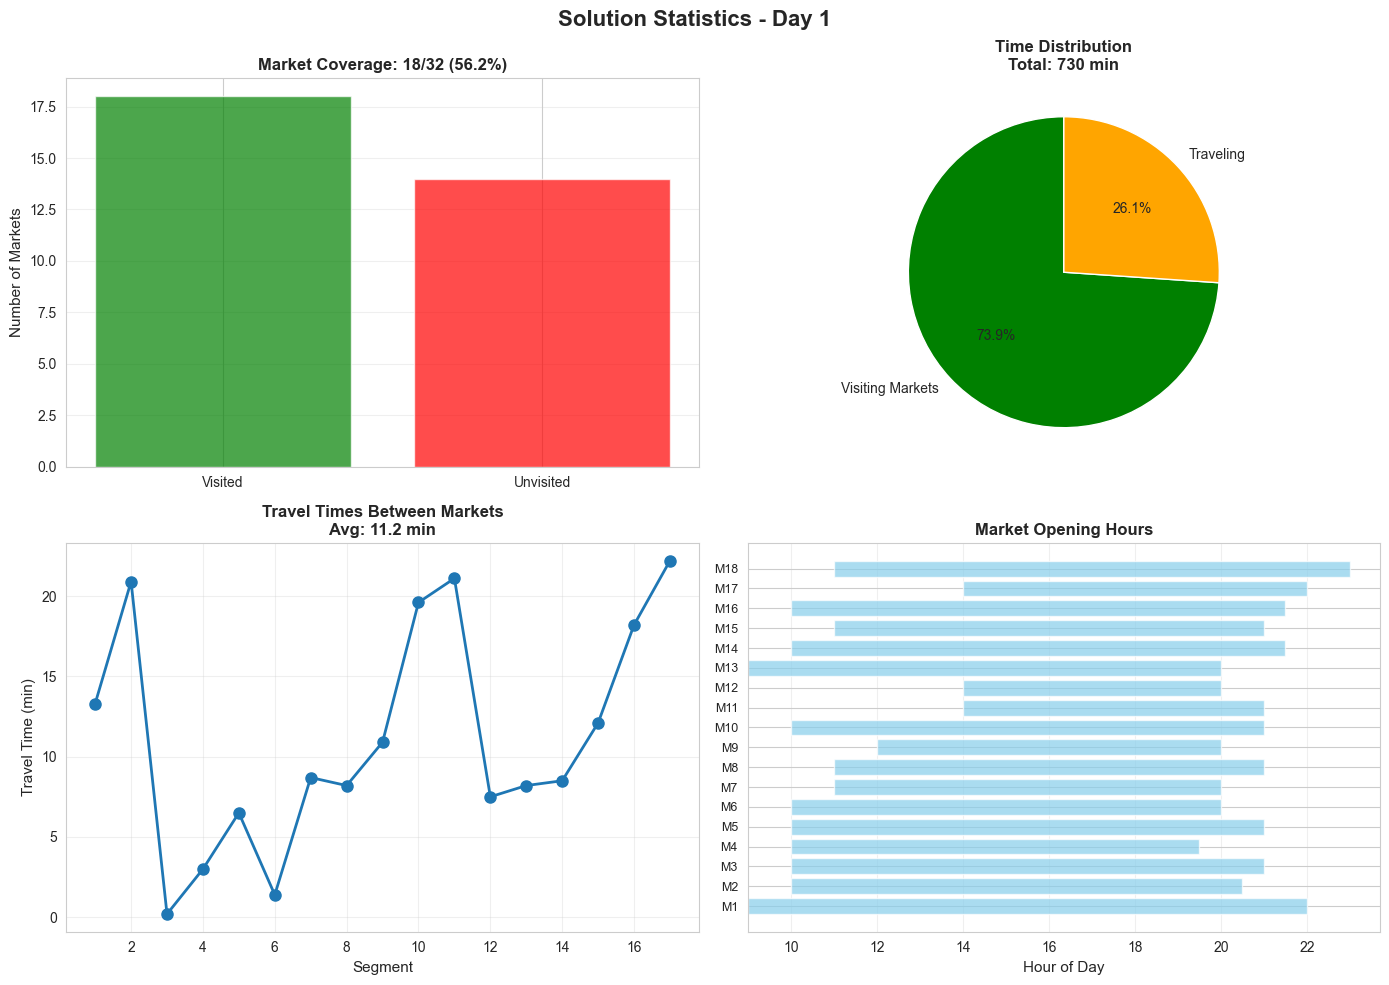

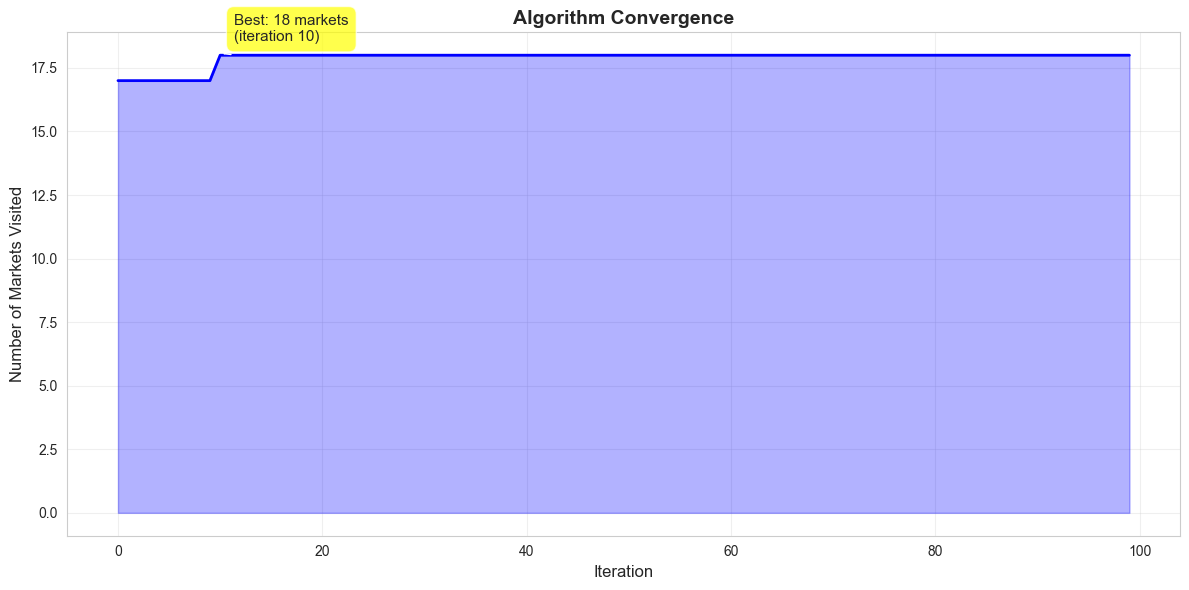

In [16]:
# Save all visualizations
viz.plot_route_map(aco_solution, save=True, filename='notebook_route.png')
viz.plot_gantt_chart(aco_solution, save=True, filename='notebook_gantt.png')
viz.plot_statistics(aco_solution, save=True, filename='notebook_stats.png')
viz.plot_convergence(aco.convergence_history, save=True, filename='notebook_convergence.png')

print("All visualizations saved to results/ directory")